In [3]:
import numpy as np
from scipy.optimize import minimize
import pandas as pd
import random 
import string
import matplotlib.pyplot as plt

stockPool = np.loadtxt('./fbm/fbm20+min+100.txt')
stockPool = stockPool[1:]

In [4]:
def sharpe(alloc, stocks, vol, ti, tf):
    """
    remake of sharpe calculation following 
    https://www.mlq.ai/python-for-finance-portfolio-optimization/#h1sjvcte25p1r8or1e1ngd82h2r8ha1
    uses allocation percentage instead of weights
    """
    Rp = 0
    var = 0
    Rf = 0.010
    for i,j in enumerate(stocks): 
        stepReturn = 100*np.diff(stockPool[j][ti:tf])/stockPool[j][ti:tf-1]
        Rp += alloc[i]*vol*np.mean(stepReturn)
        var += alloc[i]*alloc[i]*vol*vol*np.var(stepReturn)
    stdp = np.sqrt(var)
    
    #print(Rp,stdp)
    if stdp == 0:
        print("dividebyzero")
    return -(Rp-Rf)/stdp

In [32]:
class portfolio:
    
    def __init__(self,name,size,volume):
        self.volume = volume
        self.stocks = np.random.choice(np.arange(20), size=size, replace=False) # REPLACE
        self.alloc = dict.fromkeys(self.stocks,1/size) #init with a sharpe function,
        self.weights = dict.fromkeys(self.stocks,1) # put in dictionary for easy change
        self.orders = np.zeros(size)
        self.portfID = str(name)
        self.sharpe = np.asarray([])
        self.initAlloc = np.asarray([])
        self.sharpeNonOpt = np.asarray([])
        self.stockChars = pd.DataFrame()
    
    def optimize(self, t = 992,first=False):
        """
        initialize weights based on datapoints before the 5 day week
        """
        ti = t-900
        
        def check_sum(alloc):
            return np.sum(alloc)-1
        cons = ({'type':'eq','fun':check_sum})
        
        bounds = []
        for i in range(len(self.stocks)):
            bounds.append((0,1))
        
        opt= (minimize(sharpe, 
                      list(self.alloc.values()), 
                      args=(self.stocks,self.volume,ti,t), 
                      method='SLSQP', 
                      bounds=bounds,
                      constraints=cons)['x'])
        self.sharpe = np.append(self.sharpe,-sharpe(opt,self.stocks,self.volume,ti,t))
        #print('opt: ',opt)
        #print('sum opt: ', np.sum(opt))
        # update self.alloc
        if first:
            self.initAlloc = opt
            self.sharpeNonOpt = np.append(self.sharpeNonOpt,-sharpe(self.initAlloc,self.stocks,self.volume,ti,t))
            for i,j in enumerate(self.stocks):
                self.weights[j] = round(opt[i]*self.volume/stockPool[j][992])
                self.alloc[j] = opt[i]
            print(-sharpe(list(self.alloc.values()),self.stocks,self.volume,ti,t))
        else:
            self.sharpeNonOpt = np.append(self.sharpeNonOpt,-sharpe(self.initAlloc,self.stocks,self.volume,ti,t))
            #print(self.sharpeNonOpt)
            for i,j in enumerate(self.stocks):
                self.alloc[j] = opt[i]
            return opt
    
    def characterize(self, tf):
        """
        returns info of the stocks leading up to the optimization,
        such as variance of each stock and the gap between highest and lowest
        """
        ti = tf-900        
        
        for stock in self.stocks:
            stepReturn = 100*np.diff(stockPool[stock][ti:tf])/stockPool[stock][ti:tf-1]
            var = np.var(stepReturn)
            std = np.sqrt(var)
            mean = np.mean(stepReturn)
            char = pd.DataFrame({'time':[tf], "portfolio":self.portfID,'stock':stock,'mean':mean,'var':var,'std':std})
            self.stockChars = pd.concat([self.stockChars,char])
        

    def order(self, time):
        """
        calls optimize to find opt alloc
        returns the orders to be added to the broker dataframe
        immediately adjusts weights for sold stocks
        """
        opt = self.optimize(t=time)
        optweights = []
        for i,j in enumerate(self.stocks):
            optweights.append(round(opt[i]*self.volume/stockPool[j][time]))
        
        self.orders = np.asarray(optweights) - list(self.weights.values())
        orderList = pd.DataFrame({'time':time, "portfolio":self.portfID,"stock":self.stocks, "order": self.orders})
        
        # update weights that have been sent off
        i = 0
        for stock,weight in self.weights.items():
            if self.orders[i]<0:
                self.weights[stock] = weight + self.orders[i]
            i+=1
        return orderList
    
    def buy(self,stock,volume):
        """
        adjust recently bought stocks
        """
        
        #print(self.weights)
        self.weights[stock] = self.weights[stock] + volume
        #print(self.weights)
        

In [22]:
def portfGen(n=5):
    traderIDs = {}
    
    def randString(length = 5):
        letters = string.ascii_lowercase
        return ''.join(random.sample(letters,length))
    
    for i in range(n):
        name = randString()
        print(name)
        while name in traderIDs:
            name = randString()
        vol = 10**np.random.randint(3,6)
        traderIDs[name] = portfolio(name,np.random.randint(8,12),vol)
        traderIDs[name].optimize(first=True)
        
    return traderIDs
    
def uniquePortfGen(n=5, availStocks = np.shape(stockPool)[0]):
    traderIDs = {}
    
    def randString(length = 5):
        letters = string.ascii_lowercase
        return ''.join(random.sample(letters,length))
    dist = np.arange(availStocks).reshape((5,4))
    
    for i in range(n):
        name = randString()
        print(name)
        while name in traderIDs:
            name = randString()
        vol = 10**6
        traderIDs[name] = portfolio(name,int(availStocks/n),vol)
        traderIDs[name].stocks = dist[i]
        traderIDs[name].alloc = dict.fromkeys(traderIDs[name].stocks,int(availStocks/n)) #init with a sharpe function,
        traderIDs[name].weights = dict.fromkeys(traderIDs[name].stocks,1) # put in dictionary for easy change
        traderIDs[name].optimize(first=True)
        print(traderIDs[name].stocks)
        print(traderIDs[name].weights)
        print(traderIDs[name].alloc)
        
    return traderIDs
    

In [23]:
def brokerage(traderIDs, time, broker,totalOrders):
    """
    generates the brokker list which splits
    into potMatch (sales) and notMatch (back to broker)
    
    can be used to look at the total submitted orders...
    """
    for key,portf in traderIDs.items():
        portf.characterize(time)
        orderList = portf.order(time=time)
        broker = pd.concat([broker,orderList])
        totalOrders = pd.concat([totalOrders,orderList[orderList.order!=0]])
    #print(broker[broker.order!=0])

    return broker[broker.order!=0], totalOrders #remove all null orders

def match(traderIDs, broker, transactions):
    """
    does potMatch and notMatch
    """
    potMatch = broker[broker.groupby('stock').stock.transform(len) > 1] # removes all single orders
    notMatch = broker[broker.groupby('stock').stock.transform(len) == 1]
    
    for stock in (potMatch.stock.unique()): 
        # go through each stock and try to fill orders
        stockSearch = (potMatch[potMatch.stock == stock])
        buy = stockSearch[stockSearch.order > 0]
        sell = stockSearch[stockSearch.order < 0]
        if len(buy) == 0:
            notMatch = pd.concat([notMatch,sell])
        elif len(sell) == 0:
            notMatch = pd.concat([notMatch,buy])
        else:
            buy = buy.sort_values(by=["time",'order'],ascending=[True,False])
            sell = sell.sort_values(by=["time",'order'],ascending=[True,True])

            #print("BUY")
            #print(buy)
            #print("SELL")
            #print(sell)

            while len(buy) != 0 and len(sell) != 0:
                # uncomment prints to check logic
                # may want to include cancelling orders
                
                buy.reset_index(inplace=True,drop=True)
                sell.reset_index(inplace=True,drop=True)
                # iterate until no more matches
                sID = 0 # always look at the most important selling order first 
                #print(buy)
                #print(sell)
                sVol = sell.iloc[sID].order #selling amount

                #else:
                # algorithm that matches s with a b and updates sell and buy rows, take min and subtract until 0
                bMatch = buy.iloc[0]
                bVol = bMatch.order

                Vol = min(abs(sVol),abs(bVol))
                ToS = max(sell.iloc[sID].time, bMatch.time)

                sale = pd.DataFrame({"ToS":[ToS], "stock":stock, "seller": sell.iloc[sID].portfolio, 
                                     "buyer": bMatch.portfolio, "volume": Vol, 
                                     "tradeID": str(ToS)+'|'+str(stock)+str(sell.iloc[sID].portfolio)
                                    +str(bMatch.portfolio)+str(-sVol)})

                transactions = pd.concat([transactions,sale])


                sell.set_value(sID, 'order', sell.iloc[sID].order + Vol)
                buy.set_value(0, 'order', bVol - Vol)


                #print("sale")

                #update buyer weights
                #print(bMatch.portfolio)
                #print(traderIDs[bMatch.portfolio])
                buyer = traderIDs[bMatch.portfolio]
                buyer.buy(stock,Vol)


                buy = buy[buy.order!=0]
                sell = sell[sell.order!=0]
                #print(buy)
                #print(sell)
                #print("______________ \n")

            if len(buy)==0:
                notMatch = pd.concat([notMatch,sell])
            else:
                notMatch = pd.concat([notMatch,buy])


    broker = notMatch
    return broker, transactions

def instantMatch(traderIDs, broker, transactions):
    """
    instantly matches orders with a seller/buyer outside
    """
    
    broker = broker.sort_values(by='time', ascending=True)      
    broker.reset_index(inplace=True,drop=True)
    
    for sID in range(len(broker)):
    # iterate through all broker orders

        Vol = broker.iloc[sID].order #selling amount
        ToS = broker.iloc[sID].time
        stock = broker.iloc[sID].stock
        trader = traderIDs[broker.iloc[sID].portfolio]

        if Vol > 0:
            trader.buy(stock,Vol)
            sale = pd.DataFrame({"ToS":[ToS], "stock":stock, "seller": 'world', 
                             "buyer": trader.portfID, "volume": Vol, 
                             "tradeID": str(ToS)+'|'+str(stock)+str('world')
                            +str(trader.portfID)+str(Vol)})
        else:
            sale = pd.DataFrame({"ToS":[ToS], "stock":stock, "seller": trader.portfID, 
                             "buyer": 'world', "volume": Vol, 
                             "tradeID": str(ToS)+'|'+str(stock)+str('world')
                            +str(trader.portfID)+str(Vol)})

        transactions = pd.concat([transactions,sale])


        broker.set_value(sID, 'order', 0)
    broker = broker[broker.order!=0]
    
    if len(broker) != 0:
        print('OOPS len(broker) != 0')

        #print("sale")

        #update buyer weights
        #print(bMatch.portfolio)
        #print(traderIDs[bMatch.portfolio])


    
    return broker, transactions

In [33]:
traderIDs = portfGen()

ybtzi
0.20746787280427628
fklpg
0.12072157575431403
yqion
0.19485601224695512
gndya
0.1980091197511855
hiwck
0.1425205510807948


In [34]:
transactions = pd.DataFrame()
totalOrders = pd.DataFrame()
broker = pd.DataFrame()

for t in range(992,1000):
    broker, totalOrders = brokerage(traderIDs, t, broker, totalOrders)
    broker, transactions = instantMatch(traderIDs, broker, transactions)
    print(t)
    

992


/home/braedyn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:129: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


993
994
995
996
997
998
999


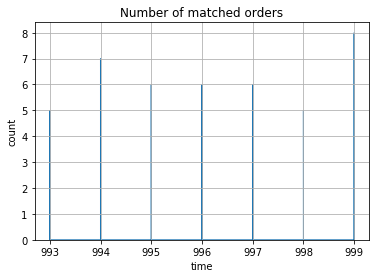

In [35]:
transactions.sort_values(by='ToS', inplace=True)
transactions.reset_index(inplace=True,drop=True)
transactions.hist(column='ToS', bins=7000,histtype='step')
plt.title("Number of matched orders")
plt.xlabel("time")
plt.ylabel("count")
plt.show()
#plt.savefig('fbm2_transcations_random.png')

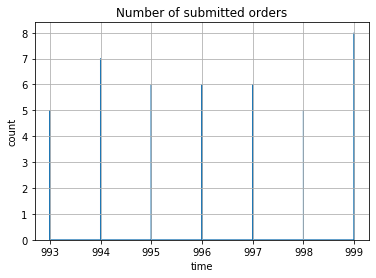

In [36]:
totalOrders.sort_values(by=['time','portfolio'], inplace=True)
totalOrders.reset_index(inplace=True,drop=True)
totalOrders.hist(column='time',histtype='step',bins=7000)
plt.title("Number of submitted orders")
plt.xlabel("time")
plt.ylabel("count")
plt.show()
#plt.savefig('fbm2_totalOrders_random.png')

In [45]:
chars = traderIDs['ybtzi'].stockChars
chars.loc[chars['time']==995]

,time,portfolio,stock,mean,var,std
0,995,ybtzi,15,0.025649,0.377619,0.614507
0,995,ybtzi,14,-0.024975,0.235689,0.485478
0,995,ybtzi,8,0.027127,0.218797,0.467758
0,995,ybtzi,2,0.054550,0.200444,0.447710
0,995,ybtzi,19,0.052656,0.198390,0.445410
0,995,ybtzi,11,0.039765,0.511351,0.715088
0,995,ybtzi,1,0.023980,0.087788,0.296291
0,995,ybtzi,4,0.008796,0.465275,0.682110
0,995,ybtzi,7,-0.006600,0.407821,0.638608
0,995,ybtzi,18,-0.016816,0.054713,0.233908


In [108]:
#transactions.to_csv('fbm2_transactions_random.csv',index = True)
#totalOrders.to_csv('fbm2_totalOrders_random.csv', index = True)

In [162]:
uniqueTraderIDs = uniquePortfGen()

djruh
0.1735450779680366
[0 1 2 3]
{0: 0.0, 1: 898.0, 2: 1320.0, 3: 903.0}
{0: 6.830473686658678e-18, 1: 0.35908691433705775, 2: 0.35835704702313775, 3: 0.2825560386398046}
hjmxr
0.012717180641826772
[4 5 6 7]
{4: 4615.0, 5: 2828.0, 6: 0.0, 7: 0.0}
{4: 0.5766340199067852, 5: 0.4233659800932147, 6: 1.5612511283791264e-17, 7: 8.61940727125976e-17}
hipzw
0.08404777255706417
[ 8  9 10 11]
{8: 2334.0, 9: 416.0, 10: 0.0, 11: 2199.0}
{8: 0.5557120437896949, 9: 0.07443548975329199, 10: 0.0, 11: 0.36985246645701325}
wizey
0.04199003478905843
[12 13 14 15]
{12: 0.0, 13: 1639.0, 14: 0.0, 15: 3638.0}
{12: 1.0408340855860843e-17, 13: 0.2864425778256993, 14: 0.0, 15: 0.7135574221743007}
uitcq
0.12427862370144434
[16 17 18 19]
{16: 778.0, 17: 796.0, 18: 0.0, 19: 1916.0}
{16: 0.3184307399652288, 17: 0.1335267185063964, 18: 9.324138683375338e-18, 19: 0.5480425415283748}


In [163]:
uniqTransactions = pd.DataFrame()
uniqTotalOrders = pd.DataFrame()
uniqBroker = pd.DataFrame()

for t in range(992,np.shape(stockPool)[1]):
    uniqBroker, uniqTotalOrders = brokerage(uniqueTraderIDs, t, uniqBroker, uniqTotalOrders)
    uniqBroker, uniqTransactions = instantMatch(uniqueTraderIDs, uniqBroker, uniqTransactions)
    print(t)

992
993


/home/braedyn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:128: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1

2635
2636
2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647
2648
2649
2650
2651
2652
2653
2654
2655
2656
2657
2658
2659
2660
2661
2662
2663
2664
2665
2666
2667
2668
2669
2670
2671
2672
2673
2674
2675
2676
2677
2678
2679
2680
2681
2682
2683
2684
2685
2686
2687
2688
2689
2690
2691
2692
2693
2694
2695
2696
2697
2698
2699
2700
2701
2702
2703
2704
2705
2706
2707
2708
2709
2710
2711
2712
2713
2714
2715
2716
2717
2718
2719
2720
2721
2722
2723
2724
2725
2726
2727
2728
2729
2730
2731
2732
2733
2734
2735
2736
2737
2738
2739
2740
2741
2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777
2778
2779
2780
2781
2782
2783
2784
2785
2786
2787
2788
2789
2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800
2801
2802
2803
2804
2805
2806
2807
2808
2809
2810
2811
2812
2813
2814
2815
2816
2817
2818
2819
2820
2821
2822
2823
2824
2825
2826
2827
2828
2829
2830
2831
2832
2833
2834


4274
4275
4276
4277
4278
4279
4280
4281
4282
4283
4284
4285
4286
4287
4288
4289
4290
4291
4292
4293
4294
4295
4296
4297
4298
4299
4300
4301
4302
4303
4304
4305
4306
4307
4308
4309
4310
4311
4312
4313
4314
4315
4316
4317
4318
4319
4320
4321
4322
4323
4324
4325
4326
4327
4328
4329
4330
4331
4332
4333
4334
4335
4336
4337
4338
4339
4340
4341
4342
4343
4344
4345
4346
4347
4348
4349
4350
4351
4352
4353
4354
4355
4356
4357
4358
4359
4360
4361
4362
4363
4364
4365
4366
4367
4368
4369
4370
4371
4372
4373
4374
4375
4376
4377
4378
4379
4380
4381
4382
4383
4384
4385
4386
4387
4388
4389
4390
4391
4392
4393
4394
4395
4396
4397
4398
4399
4400
4401
4402
4403
4404
4405
4406
4407
4408
4409
4410
4411
4412
4413
4414
4415
4416
4417
4418
4419
4420
4421
4422
4423
4424
4425
4426
4427
4428
4429
4430
4431
4432
4433
4434
4435
4436
4437
4438
4439
4440
4441
4442
4443
4444
4445
4446
4447
4448
4449
4450
4451
4452
4453
4454
4455
4456
4457
4458
4459
4460
4461
4462
4463
4464
4465
4466
4467
4468
4469
4470
4471
4472
4473


5913
5914
5915
5916
5917
5918
5919
5920
5921
5922
5923
5924
5925
5926
5927
5928
5929
5930
5931
5932
5933
5934
5935
5936
5937
5938
5939
5940
5941
5942
5943
5944
5945
5946
5947
5948
5949
5950
5951
5952
5953
5954
5955
5956
5957
5958
5959
5960
5961
5962
5963
5964
5965
5966
5967
5968
5969
5970
5971
5972
5973
5974
5975
5976
5977
5978
5979
5980
5981
5982
5983
5984
5985
5986
5987
5988
5989
5990
5991
5992
5993
5994
5995
5996
5997
5998
5999
6000
6001
6002
6003
6004
6005
6006
6007
6008
6009
6010
6011
6012
6013
6014
6015
6016
6017
6018
6019
6020
6021
6022
6023
6024
6025
6026
6027
6028
6029
6030
6031
6032
6033
6034
6035
6036
6037
6038
6039
6040
6041
6042
6043
6044
6045
6046
6047
6048
6049
6050
6051
6052
6053
6054
6055
6056
6057
6058
6059
6060
6061
6062
6063
6064
6065
6066
6067
6068
6069
6070
6071
6072
6073
6074
6075
6076
6077
6078
6079
6080
6081
6082
6083
6084
6085
6086
6087
6088
6089
6090
6091
6092
6093
6094
6095
6096
6097
6098
6099
6100
6101
6102
6103
6104
6105
6106
6107
6108
6109
6110
6111
6112


7552
7553
7554
7555
7556
7557
7558
7559
7560
7561
7562
7563
7564
7565
7566
7567
7568
7569
7570
7571
7572
7573
7574
7575
7576
7577
7578
7579
7580
7581
7582
7583
7584
7585
7586
7587
7588
7589
7590
7591
7592
7593
7594
7595
7596
7597
7598
7599
7600
7601
7602
7603
7604
7605
7606
7607
7608
7609
7610
7611
7612
7613
7614
7615
7616
7617
7618
7619
7620
7621
7622
7623
7624
7625
7626
7627
7628
7629
7630
7631
7632
7633
7634
7635
7636
7637
7638
7639
7640
7641
7642
7643
7644
7645
7646
7647
7648
7649
7650
7651
7652
7653
7654
7655
7656
7657
7658
7659
7660
7661
7662
7663
7664
7665
7666
7667
7668
7669
7670
7671
7672
7673
7674
7675
7676
7677
7678
7679
7680
7681
7682
7683
7684
7685
7686
7687
7688
7689
7690
7691
7692
7693
7694
7695
7696
7697
7698
7699
7700
7701
7702
7703
7704
7705
7706
7707
7708
7709
7710
7711
7712
7713
7714
7715
7716
7717
7718
7719
7720
7721
7722
7723
7724
7725
7726
7727
7728
7729
7730
7731
7732
7733
7734
7735
7736
7737
7738
7739
7740
7741
7742
7743
7744
7745
7746
7747
7748
7749
7750
7751


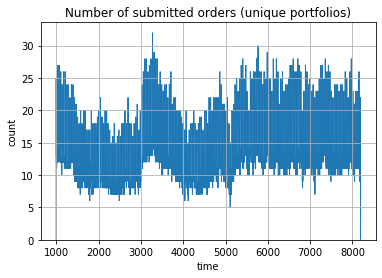

In [167]:
uniqTotalOrders.hist(column='time',histtype='step',bins=7000)
plt.title("Number of submitted orders (unique portfolios)")
plt.xlabel("time")
plt.ylabel("count")
plt.show()
#plt.savefig('fbm2_totalOrders_unique.png')
#uniqTotalOrders.to_csv("fbm2_totalOrders_unique.csv")

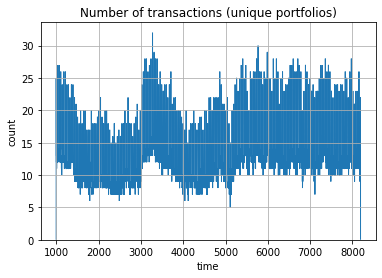

In [168]:
uniqTransactions.hist(column='ToS',histtype='step',bins=7000)
plt.title("Number of transactions (unique portfolios)")
plt.xlabel("time")
plt.ylabel("count")
plt.show()
#plt.savefig('fbm2_transactions_unique.png')
#uniqTransactions.to_csv("fbm2_transactions_unique.csv")

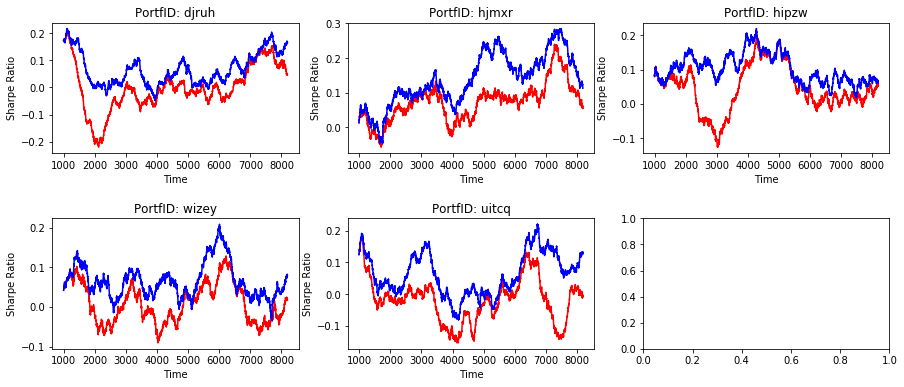

In [183]:
fig, axs = plt.subplots(2,3, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5)#, wspace=.001)

axs = axs.ravel()

n = 0
for i, v in uniqueTraderIDs.items():
    axs[n].plot(np.arange(992,8194), v.sharpeNonOpt, color = 'red')
    axs[n].plot(np.arange(992,8194), v.sharpe, color = 'blue')
    axs[n].set_title("PortfID: "+v.portfID)
    axs[n].set_ylabel("Sharpe Ratio")
    axs[n].set_xlabel('Time')
    n += 1
#plt.savefig("fbm2_sharpecomparison.png")
#plt.show()

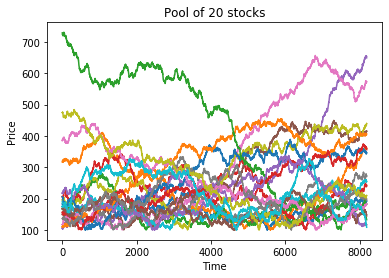

In [186]:
for i in range(20):
    plt.plot(np.arange(2**13+1), stockPool[i])
    
plt.title("Pool of 20 stocks")
plt.xlabel("Time")
plt.ylabel("Price")
#plt.savefig("./forsiewann/stockpool.png")

In [188]:
tttt = np.asarray([1,2,3,4,5,6,7])
np.diff(tttt)/tttt[:-1]

array([1.        , 0.5       , 0.33333333, 0.25      , 0.2       ,
       0.16666667])